In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
#np.set_printoptions(precision=3)
np.set_printoptions(precision=3, suppress=True)

### Initialial visulation

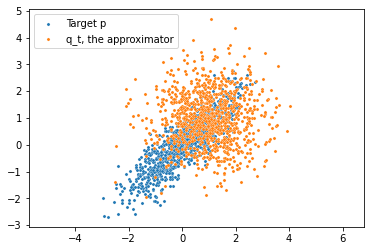

In [2]:
mu_p = torch.tensor([0.0, 0.0])
scale_p = torch.tensor([[1.0000, 0.0000],
                        [0.8, 0.5]])
cov_p = scale_p@scale_p.T

p_data = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu_p, covariance_matrix=cov_p)

mu_q = torch.tensor([1.0, 1.0])
scale_q = torch.tensor([[1.0, 0], [0, 1.0]])

cov_q = scale_q@scale_q.T
q_g = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu_q, covariance_matrix=cov_q)

x_p = p_data.sample([1000])
x_q = q_g.sample([1000])
sns.scatterplot(x=x_p[:, 0], y=x_p[:, 1], s=10, label='Target p')
sns.scatterplot(x=x_q[:, 0], y=x_q[:, 1], s=10, label='q_t, the approximator')
plt.axis('equal')
plt.legend()
plt.show()


In [3]:
print('Target dist')
print('mu_p', mu_p.numpy())
print('cov_p', (scale_p @ scale_p.T).numpy())

Target dist
mu_p [0. 0.]
cov_p [[1.   0.8 ]
 [0.8  0.89]]


In [4]:
# Define the log prob of gaussian 
def log_prob(mu, scale, x):
    cov = scale@scale.T
    dim = x.shape[1]
    a = -0.5 * (dim * np.log(2 * np.pi) + torch.log(1e-8+torch.det(cov)))
    b =  -0.5*torch.sum((x - mu) @ torch.inverse(cov) * (x - mu), axis=1)
    return a + b

# define f divergence as f(r)

def f(r, methood='Rkl'):
    if methood=='Rkl':
        return -torch.log(r)
    elif methood=='Fkl':
        return r*torch.log(r)
    elif methood=='Chi':
        return (r-1)**2
    elif methood=='Hellinger':
        return (torch.sqrt(r)-1)**2
    elif methood=='Js':
        return -(r+1)*torch.log((1+r)/2) + r*torch.log(r)

def h(logr, methood='exp'):
    if methood=='exp':
        return torch.exp(1.2*logr)
    elif methood=='arcsinh':
        return torch.arcsinh(logr**3)
    elif methood=='tanh':
        return torch.tanh(logr**3)
    

def train(detach=False, func='f', method='Rkl', number_iter=1000, lr=0.01):
    
    mu_q = torch.tensor([1.0, 1.0])
    scale_q = torch.tensor([[1.0, 0], [0, 1.0]])

    mu_q.requires_grad = True
    scale_q.requires_grad = True
    opt = torch.optim.Adam([mu_q, scale_q], lr=lr)
    
    for i in range(number_iter):
        opt.zero_grad()
        
        z = torch.randn([1000, 2])
        
        # reparameterization trick
        x = mu_q + z @ scale_q.T
        if not detach:
            log_ratio = log_prob(mu_p, scale_p, x) - log_prob(mu_q, scale_q, x)
        else:
            log_ratio = log_prob(mu_p, scale_p, x) - log_prob(mu_q.detach(), scale_q.detach(), x)
            
        r = torch.exp(log_ratio)
        if func == 'f':
            loss = torch.mean(f(r, method))
        if func == 'h':
            loss = -torch.mean(h(log_ratio, method))  
        loss.backward()
        opt.step()
        
    print('Minimize div:', method)
    print('final mu_q', mu_q.detach().numpy())
    print('final cov_q', (scale_q @ scale_q.T).detach().numpy())
    
    sns.scatterplot(x=x_p[:, 0], y=x_p[:, 1], s=10, label='Target p', alpha=0.5)
    sns.scatterplot(x=x.detach()[:, 0], y=x.detach()[:, 1], s=5, label='q_t', color='r', alpha=0.8)
    plt.axis('equal')
    plt.legend()
    plt.show()

#### Variational Inference  
min $D_f(p||q) = \int q(x) f(\frac{p(x)}{q(x)})dx$

In [5]:
print('Target dist')
print('mu_p', mu_p.numpy())
print('cov_p', (scale_p @ scale_p.T).numpy())

Target dist
mu_p [0. 0.]
cov_p [[1.   0.8 ]
 [0.8  0.89]]


Minimize div: Rkl
final mu_q [ 0.005 -0.012]
final cov_q [[0.995 0.793]
 [0.793 0.898]]


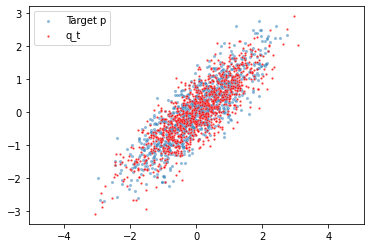

In [6]:
train(detach=False, func='f', method='Rkl', number_iter=1000, lr=0.01)
#train(detach=False, method='Fkl', number_iter=1000, lr=0.01)
#train(detach=False, method='Chi', number_iter=5000, lr=0.01)
#train(detach=False, method='Hellinger', number_iter=1000, lr=0.01)
#train(detach=False, method='Js', number_iter=1000, lr=0.01)

## GAN

Minimize div: Rkl
final mu_q [0. 0.]
final cov_q [[1.   0.8 ]
 [0.8  0.89]]


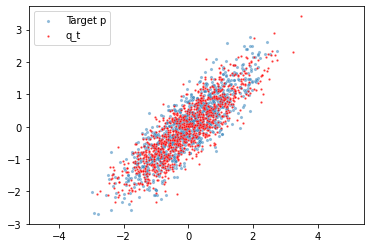

In [7]:
train(detach=True, method='Rkl', number_iter=1000, lr=0.01)
#train(detach=True, method='Fkl', number_iter=1000, lr=0.01)
#train(detach=True, method='Chi', number_iter=3000, lr=0.01)
#train(detach=True, method='Hellinger', number_iter=1000, lr=0.01)
#train(detach=True, method='Js', number_iter=1000, lr=0.01)


Note that $r(x) = \frac{p(x)}{q(x)}$ 
$$
D_f(p||q) = \int q(x) f\big((r(x)\big)dx = -\int q(x) h\big(\log r(x) \big)dx
$$
Therefore, $$f\big(r\big) = - h\big(\log r \big)$$
For example, KL divergence, $f(r) = -\log r, h(\log r) = \log r$

Let $h(\log r) = \exp(2\log r) = r^2$, So we have $f(r)= -r^2$, $h$ is increasing but $f$ is concave



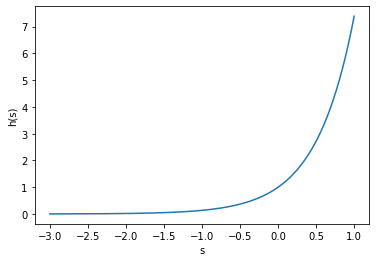

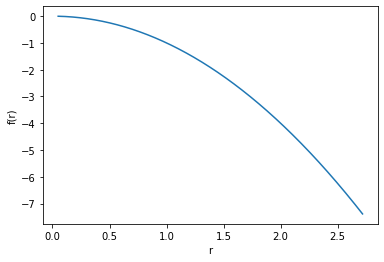

In [8]:
logr = torch.linspace(-3, 1, 1000)
r = torch.exp(logr)
hlogr = torch.exp(2*logr)
fr = -hlogr
plt.plot(logr, hlogr)
plt.xlabel('s')
plt.ylabel('h(s)')

plt.show()
plt.plot(r, fr)
plt.xlabel('r')
plt.ylabel('f(r)')
plt.show()

Train VI with h=exp(2logr)
Minimize div: exp
final mu_q [0.611 2.036]
final cov_q [[ 4.075 -0.493]
 [-0.493  0.957]]


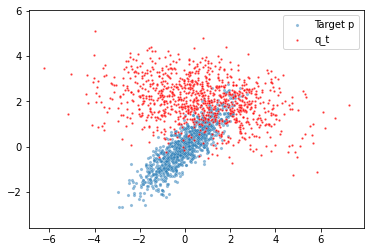

In [9]:
print('Train VI with h=exp(1.1logr)')
train(detach=False, func='h', method='exp', number_iter=2000, lr=0.01)

Train VI with h=exp(2logr)
Minimize div: exp
final mu_q [ 0. -0.]
final cov_q [[1.   0.8 ]
 [0.8  0.89]]


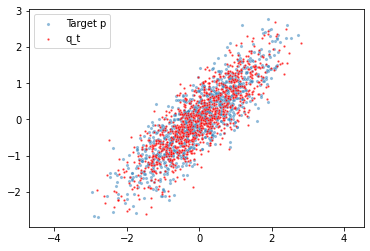

In [10]:
print('Train VI with h=exp(2logr)')
train(detach=True, func='h', method='exp', number_iter=10000, lr=0.002)